# Hidden Markov Model POS Tagger & The Viterbi Algorithm
In this project we will implement a Hidden Markov Model for Part of Speech tagging.
The objectives of this project are:
  1. Better understanding of POS
  2. Better understanding of HMM and generative sequence models.

### Introduction
Part of speech tagging is the process of determining the syntactic category of a word from the words in its surrounding context. It is often used to help disambiguate natural language phrases because it can be done quickly with high accuracy. Tagging can be used for many NLP tasks like determining correct pronunciation during speech synthesis (for example, dis-count as a noun vs dis-count as a verb), for information retrieval, and for word sense disambiguation.

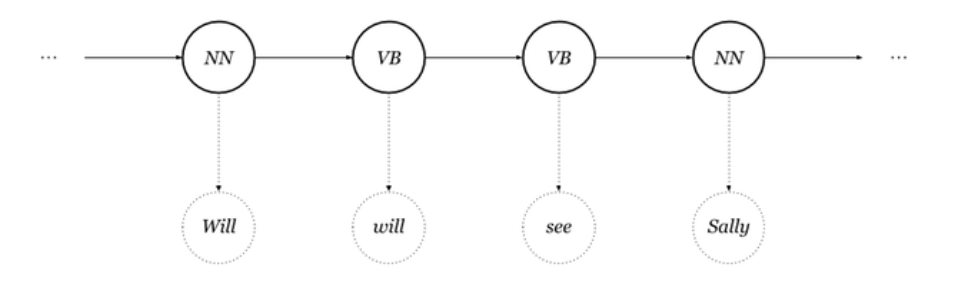

More information on HMM: [here](https://web.stanford.edu/~jurafsky/slp3/A.pdf)

### Data and documentation
Extracted tokens and POS tags are taken from the English Web Treebank via the Universal:
* Dependencies Project (http://universaldependencies.org/).

Tagset overviews:
* Universal: http://people.cs.georgetown.edu/nschneid/p/UPOS-English.pdf
* Penn (full new-style tagset): https://spacy.io/docs/usage/pos-tagging#pos-tagging-english
* Penn (examples):
http://surdeanu.info/mihai/teaching/ista555-fall13/readings/PennTreebankTagset.html
* Data for training and testing: [training](https://www.dropbox.com/s/dmmeo0froqsw2sf/en-ud-train.upos.tsv?dl=0) and [development](https://www.dropbox.com/s/xzz799pp541z2t4/en-ud-dev.upos.tsv?dl=0) datasets.



In [156]:
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/en-ud-train.upos.tsv"
path_test = "/content/drive/My Drive/Colab Notebooks/en-ud-dev.upos.tsv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
from math import log, isfinite
from collections import Counter
import math
import numpy as np
import sys, os, time, platform, nltk, random

### Reading the data
Extracting tuples of (word, tag) for each sentence in the given path

In [158]:
def read_annotated_sentence(f):
    line = f.readline()
    if not line:
        return None
    sentence = []
    while line and (line != "\n"):
        line = line.strip()
        word, tag = line.split("\t", 2)
        sentence.append( (word, tag) )
        line = f.readline()
    return sentence

def load_annotated_corpus(filename):
    sentences = []
    with open(filename, 'r', encoding='utf-8') as f:
        sentence = read_annotated_sentence(f)
        while sentence:
            sentences.append(sentence)
            sentence = read_annotated_sentence(f)
    return sentences

##########################
###### GLOBAL VARS #######
##########################

START = "<DUMMY_START_TAG>"
END = "<DUMMY_END_TAG>"
UNK = "<UNKNOWN>"
allTagCounts = Counter()
# use Counters inside these
perWordTagCounts = {}
emissionCounts = {}
transitionCounts = {}
# log probability distributions: do NOT use Counters inside these because
# missing Counter entries default to 0, not log(0)
A = {} #transitions probabilities
B = {} #emmissions probabilities

allWordCounts = Counter()

In [159]:
file_name = path
s = load_annotated_corpus(file_name)

### Populating data structures
* allTagCounts - Counter for all tags in the training data
* perWordTagCounts - Counter for all pairs (word, tag)
* allWordCounts = Counter for all words in the training data
* emissionCounts - Normalized smoothed counts for (word, tag)
* transitionCounts - Normalized smoothed counts for transition (tag, tag)
* A - #transitions log probabilities 
* B - #emmissions log probabilities


In [160]:
def count_total_tags_or_words(tagged_sentences, isTag=True):
  """
        Counting the instances of each word or tag
        :param tagged_sentences: list of sentences which each sentence composed by list of (w,t)
        :param isTag: True for counting tags, otherwise counting words
        :return: Counter of all tags/words
    """
  if isTag:
    all_tags_joined = [tag[1] for sentence in tagged_sentences for tag in sentence]
  else:
    all_tags_joined = [tag[0] for sentence in tagged_sentences for tag in sentence]
  result = Counter(all_tags_joined)
  return result

def count_tags_per_word(tagged_sentences):
  """
        Counting for each word the number of times it appears with each tag associated with it.
        :param tagged_sentences: list of sentences which each sentence composed by list of (w,t)
    """
  for sentence in tagged_sentences:
    for w_t_tuple in sentence:
      if w_t_tuple in perWordTagCounts.keys():
        perWordTagCounts[w_t_tuple] += 1
      else:
        perWordTagCounts[w_t_tuple] = 1

def create_transition_counts(tagged_sentences):
  """
        Creating the transition dictionary by the next function:
            P(ti|ti-1) = C(ti-1, ti)/C(ti)

        Performing Laplace smoothing for avoiding division in zero and create prob for missing pairs.
        :param tagged_sentences: list of sentences which each sentence composed by list of (w,t)
  """
  for sentence in tagged_sentences:

    # Creating the first state of ('START' -> first tag)
    first_tuple = (START, sentence[0][1])
    if first_tuple in transitionCounts.keys():
      transitionCounts[first_tuple] += 1
    else:
      transitionCounts[first_tuple] = 1

    # Creating the markov tags chain 
    for idx in range(len(sentence)-1):
      currentTagTuple = (sentence[idx][1], sentence[idx+1][1])
      if currentTagTuple in transitionCounts.keys():
        transitionCounts[currentTagTuple] += 1
      else:
        transitionCounts[currentTagTuple] = 1

    # Creating the last state of (last tag -> 'END)
    last_tuple = (sentence[len(sentence) - 1][1], END)
    if last_tuple in transitionCounts.keys():
      transitionCounts[last_tuple] += 1
    else:
      transitionCounts[last_tuple] = 1

  # Filling missing transitions
  all_tags = list(allTagCounts.keys()) + [START, END]
  for tag in all_tags:
    if tag != END:
      for s_tag in all_tags:
        if s_tag != START:
          missing_tranisition = (tag, s_tag)
          if missing_tranisition not in transitionCounts.keys():
            transitionCounts[missing_tranisition] = 0

  # Normalizing
  for tags_tuple in transitionCounts.keys():
    # Number of tags: C(ti)
    cur_count_tag = 0
    if tags_tuple[0] == START:
      cur_count_tag = len(tagged_sentences)
    else:
      cur_count_tag = allTagCounts[tags_tuple[0]]
    
    # Laplace smoothing
    smoothed_value = (transitionCounts[tags_tuple] + 1)/(cur_count_tag + len(transitionCounts))
    transitionCounts[tags_tuple] = float(smoothed_value)

def create_emission_counts(tagged_sentences, allTagCounts):
  """
    Creating the emission dictionary by the next function:
        P(wi|ti) = C(ti,wi)/C(ti)
    :param allTagCounts: (Counter) all available tags
    :param tagged_sentences: list of sentences which each sentence composed by list of (w,t)

  """
  # OOV: 
  # Creating emission of UNKNOWN to each tag to cover OOV
  for tag in np.unique(list(allTagCounts.keys())):
    new_oov = (UNK, tag)
    perWordTagCounts[new_oov] = 0

  for w_t_tuple in perWordTagCounts.keys():
    # Number of tags: C(ti)
    cur_count_tag = 0
    if w_t_tuple[1] == UNK:
      cur_count_tag = len(tagged_sentences)
    else:
      cur_count_tag = allTagCounts[w_t_tuple[1]]

    # Laplace smoothing
    normalized_value = (perWordTagCounts[w_t_tuple] + 1)/(cur_count_tag + len(perWordTagCounts))
    emissionCounts[w_t_tuple] = normalized_value


Evaluating the functions above

In [161]:
# allTagCounts = count_total_tags_or_words(s)
# allWordCounts = count_total_tags_or_words(s, isTag=False)
# count_tags_per_word(s)
# create_transition_counts(s)
# create_emission_counts(s)

Wrapper function for generating all needed data structures

In [162]:
def learn_params(tagged_sentences):
  """
    Populates and returns the allTagCounts, perWordTagCounts, transitionCounts,
    and emissionCounts data-structures.
    allTagCounts and perWordTagCounts should be used for baseline tagging and
    should not include pseudocounts, dummy tags and unknowns.
    The transitionCounts and emmissionCounts
    should be computed with pseudo tags and should be smoothed.
    A and B should be the log-probability of the normalized counts, based on
    transitionCounts and  emmissionCounts

      Args:
        tagged_sentences: a list of tagged sentences, each tagged sentence is a
         list of pairs (w,t), as retunred by load_annotated_corpus().

     Return:
        [allTagCounts,perWordTagCounts,transitionCounts,emissionCounts,A,B] (a list)
  """  
  global allWordCounts
  global allTagCounts  
  global A
  global B
  allTagCounts = count_total_tags_or_words(tagged_sentences)
  allWordCounts = count_total_tags_or_words(tagged_sentences, isTag=False)
  count_tags_per_word(tagged_sentences)
  create_transition_counts(tagged_sentences)
  create_emission_counts(tagged_sentences, allTagCounts)

  # Creating A,B matrixes
  for key, value in transitionCounts.items():
    A[key] = math.log2(value)

  for key,value in emissionCounts.items():
    B[key] = math.log2(value)

  return [allTagCounts,perWordTagCounts,transitionCounts,emissionCounts,A,B]

Evaluating learn_param

In [163]:
allTagCounts,perWordTagCounts,transitionCounts,emissionCounts,A,B = learn_params(s)

Sanity check - think why those values makes sense

In [164]:
max(transitionCounts.values()), max(emissionCounts.values()), max(A.values()), max(B.values())

(0.6711933457817009,
 0.21145706198550987,
 -0.5751996819334168,
 -2.241563352343566)

### Baseline evaluation
Only by the perWordTag dictionary and allTagsCounts Counter, calculating the probability of a tag to be associated with a given word with no concideration of predeccesors states.

In [165]:
def get_tags_of_word(word, perWordTagCounts):
  """
    Retrieving the tags of a given word.
    :param word: (str) word
    :param perWordTagCounts: (dic) {(w,t): count}
    :return: list of (w,t)
  """
  return [(key, value) for key,value in perWordTagCounts.items() if key[0] == word]

def retrieve_most_frequent_tag_of_word(word, perWordTagCounts):
  """
    Generating the most common tag of a given word
    :param word: (str) word
    :param perWordTagCounts: (dic) {(w,t): count}
    :return:
  """
  word_tag_list = get_tags_of_word(word, perWordTagCounts)
  sorted_list = sorted(word_tag_list, key=lambda x: x[1], reverse=True)
  return sorted_list[0][0][1]

def sample_tag_by_distribution(allTagCounts):
  """
    Creating the distribution of tags and sampling one of those tags
    :param allTagCounts: (Counter) tags
    :return: (str) sampled tag
  """
  tags = list(allTagCounts.keys())
  total_instances = sum(allTagCounts.values())
  probs = [allTagCounts[x]/total_instances for x in tags]
  return np.random.choice(tags, p=probs, replace=False)

In [166]:
def baseline_tag_sentence(sentence, perWordTagCounts, allTagCounts):
    """
    Returns a list of pairs (w,t) where each w corresponds to a word
    (same index) in the input sentence. Each word is tagged by the tag most
    frequently associated with it. OOV words are tagged by sampling from the
    distribution of all tags.

    Args:
        sentence (list): a list of tokens (the sentence to tag)
        perWordTagCounts (Counter): tags per word as specified in learn_params()
        allTagCounts (Counter): tag counts, as specified in learn_params()

        Return:
        list: list of pairs
    """

    tagged_sentence = []
    for word in sentence:
      if word in allWordCounts.keys():
        tagged_sentence.append((word, retrieve_most_frequent_tag_of_word(word, perWordTagCounts)))
      else:
        tagged_sentence.append((word, sample_tag_by_distribution(allTagCounts)))

    return tagged_sentence

In [167]:
def count_correct(gold_sentence, pred_sentence):
    """Return the total number of correctly predicted tags,the total number of
    correcttly predicted tags for oov words and the number of oov words in the
    given sentence.

    Args:
        gold_sentence (list): list of pairs, assume to be gold labels
        pred_sentence (list): list of pairs, tags are predicted by tagger

    """
    assert len(gold_sentence)==len(pred_sentence)

    OOV = 0
    correctOOV = 0
    correct = 0

    for idx in range(len(gold_sentence)):
      if gold_sentence[idx] == pred_sentence[idx]:
        correct += 1
        if gold_sentence[idx][0] not in allWordCounts:
          correctOOV += 1
          OOV += 1
      else:
        if gold_sentence[idx][0] not in allWordCounts:
          OOV += 1   

    return correct, correctOOV, OOV

Evaluating the baseline tag sentence

In [168]:
dev_set = load_annotated_corpus(path_test)

In [169]:
test_s = [x[0] for x in dev_set[5]]

In [170]:
pred1 = baseline_tag_sentence(test_s, perWordTagCounts, allTagCounts)
print(count_correct(dev_set[5], pred1))

(15, 0, 1)


In [171]:
for word in test_s:
  if word not in allWordCounts.keys():
    print(word)


sheikh


Calculating the joint probability of a sentence with tags based on the transition matrix and the emission matrix

In [172]:
def joint_prob(sentence, A, B):
  """
    Returns the joint probability of the given sequence of words and tags under
    the HMM model.

    Args:
        sentence (pair): a sequence of pairs (w,t) to compute.
        A (dict): The HMM Transition probabilities
        B (dict): the HMM emmission probabilities.
  """
  p = 0   # joint log prob. of words and tags

  # Start state -> first tag probability
  first_transition_prob = A[(START, sentence[0][1])]

  # Since we are in log probabilities we can add them to each other instead of muliply the probabilities itselves
  last_tag = ""
  for idx in range(len(sentence)):
    b = sentence[idx]
    if b not in B:
      b = (UNK, b[1])
    if idx == 0:
      p += B[b] + first_transition_prob
    else:
      a = (last_tag, b[1])
      p += B[b] + A[a]
    last_tag = b[1]

  last_transition_prob = A[(sentence[len(sentence)-1][1], END)]
  p += last_transition_prob
    

  assert isfinite(p) and p<0  # Should be negative. Think why!
  return p

In [173]:
# Exmaple
assert joint_prob(dev_set[1], A, B) == -233.40810498810944

### HMM model with the Viterbi algorithm
a Markov chain is specified by the following components:


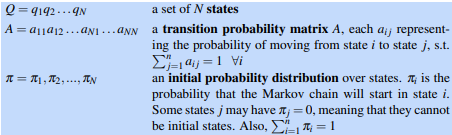

An HMM is specified by the following components:


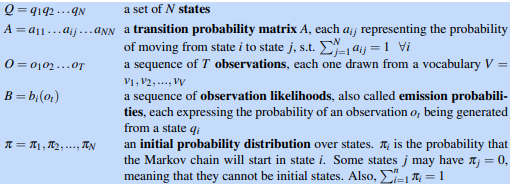

The decoding algorithm for HMMs is the Viterbi algorithm. As an instance of dynamic programming, Viterbi resembles the dynamic programming minimum edit distance algorithm:


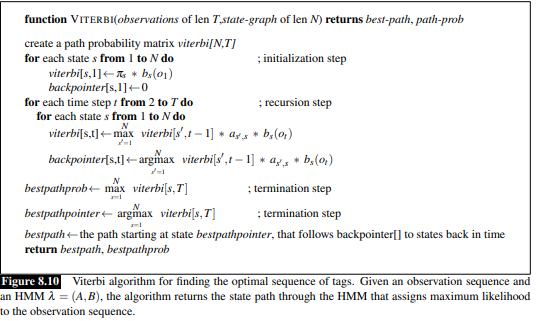

In [174]:
def create_OOV_word_tag():
  """
    Creating all possible tags for an OOV word
    :return: (list) [(OOV_word, tag_i)] for each i in the tag Counter
  """
  return [(UNK, tag) for tag in list(allTagCounts.keys())]

def get_list_of_word_tags(word):
  """
    Retrieving all tuples (word, tag) existed in the perWordTag dictionary of a given word
    :param word: (str) the word
    :return: (list) [(word, tag_i)] for each tag if (word, tag) exists
  """
  if word not in list(allWordCounts.keys()):
    return create_OOV_word_tag()
  return [x for x in perWordTagCounts if x[0] == word]

def get_word_tag(w_t_list, tag):
  """
    Helper function for the init phase of the second column in the viterbi matrix, which
        represents the initial viterbis to start with.
    Only if a (word, tag) exists in the initial emission from the START state we will consider it
        else, there is no evidence that this emission is possible based on the train set.
    :param w_t_list: (list) all (word, tag) possible from the word we are starting from.
                            [possible means if a word exists in our dictionary or it is an OOV]
    :param tag: (str) the tag we are checking for the emission possibility
    :return: (word, tag)
  """
  for tpl in w_t_list:
    if tpl[1] == tag:
      return tpl

def predict_next_best(word, tag, predecessor_list):
  """
    Predicting the best next transition probability of a current word based on the predecessor states.
    Generating all possible tag transitions and retrieving the max probability of them.
    Finally calculating the viterbi of the current state: B[(word, tag)]*MAX(transition_prob)
    :param word: (str) current state word
    :param tag: (str) current checked tag
    :param predecessor_list: (list) former states from the viterbi matrix
    :return: (3-tuple) best state, (float) current viterbi probability
  """
  log_max_prob = float('-inf')
  best_pre_state_col_state = 0

  # Generating the max probability for tag -> tag transition
  for i in range(len(predecessor_list)):
    pre_s = predecessor_list[i]
    if pre_s != float('-inf'):
      if pre_s[2] > float('-inf'):
        current_transition = (pre_s[0], tag)
        current_prob = pre_s[2] + A[current_transition]
        if log_max_prob < current_prob:
          log_max_prob = current_prob
          best_pre_state_col_state = pre_s

  # Calculating the current viterbi
  current_viterbi_prob = log_max_prob + B[(word, tag)]

  return best_pre_state_col_state, current_viterbi_prob

def get_max_probability_path(viterbi_matrix, nrow, ncol):
  """
    Retrieving the best last state according to its last probability.
    Each cell in the last column of the viterbi matrix contains 3-elements-tuple (t,r,p)
        and therefore the path will start from the last object
    :param viterbi_matrix: (2-D array) vitervi matrix
    :param nrow: (int) Number of rows
    :param ncol: (int) Number of columns
    :return: (3-elements-tuple) best state with the END dummy tag
  """
  best_state = None
  log_max_prob = 0
  for i in range(nrow):
    current_cell = viterbi_matrix[i][ncol-1]
    if current_cell != float('-inf'):
      if current_cell[0] == END and current_cell[2] < log_max_prob:
        best_state = current_cell
  return best_state

def retrace(end_item):
  """
    Returns a list of tags (retracing the sequence with the highest probability,
        reversing it and returning the list). The list should correspond to the
        list of words in the sentence (same indices).
  """
  tags_result = [end_item[0]]
  last_case = end_item[1]
  while last_case[1] != None:
    tags_result.append(last_case[0])
    last_case = last_case[1]
  tags_result.append(START)
  return tags_result[::-1]

In [175]:
def viterbi(sentence, A,B):
    """Creates the Viterbi matrix, column by column. Each column is a list of
    tuples representing cells. Each cell ("item") is a tupple (t,r,p), were
    t is the tag being scored at the current position,
    r is a reference to the corresponding best item from the previous position,
    and p is a log probability of the sequence so far).

    The function returns the END item, from which it is possible to
    trace back to the beginning of the sentence.

    Args:
        sentence (list): a list of tokens (the sentence to tag)
        A (dict): The HMM Transition probabilities
        B (dict): tthe HMM emmission probabilities.

    Return:
        obj: the last item, tagged with END. should allow backtraking.

        """
        # Hint 1: For efficiency reasons - for words seen in training there is no
        #      need to consider all tags in the tagset, but only tags seen with that
        #      word. For OOV you have to consider all tags.
        # Hint 2: start with a dummy item  with the START tag (what would it log-prob be?).
        #         current list = [ the dummy item ]
        # Hint 3: end the sequence with a dummy: the highest-scoring item with the tag END

    # Creating dimensions and initial viterbi matrix
    tags_count_row = len(allTagCounts.keys())
    words_count_col = len(sentence) + 2
    viterbi_matrix = [[float('-inf') for i in range(words_count_col)] for j in range(tags_count_row)] 

    # Initilize first column of START->tag for each tag
    idx = 0
    for tag in list(allTagCounts.keys()):
      transition_start = (START, tag)
      viterbi_matrix[idx][0] = (tag, START, A[transition_start])
      idx += 1

    # Initialize second column with first word and all possible tags for initial viterbis
    first_word = sentence[0]
    first_states = get_list_of_word_tags(first_word)
    for i in range(tags_count_row):
      former_i_state = viterbi_matrix[i][0]
      current_word_tag = get_word_tag(first_states, former_i_state[0])
      viterbi_matrix[i][0] = (START, None, viterbi_matrix[i][0][2])
      former_i_state = viterbi_matrix[i][0]
      if current_word_tag != None:
        current_prob = former_i_state[2] + B[current_word_tag]
        viterbi_matrix[i][1] = (current_word_tag[1], former_i_state, current_prob)

    # Viterbi algorithm - Iterate throught the observations updating the tracking tables
    for i in range(len(sentence)):
      if i > 0:
        viterbi_idx = i + 1
        current_word = sentence[i]
        states = get_list_of_word_tags(current_word)
        for j in range(len(states)):
          state = states[j]
          best_pre_state_col_state, current_viterbi_prob = predict_next_best(state[0], state[1], [row[i] for row in viterbi_matrix])
          viterbi_matrix[j][viterbi_idx] = (state[1], best_pre_state_col_state, current_viterbi_prob)

    # END tag transition probability
    for i in range(tags_count_row):
      if viterbi_matrix[i][words_count_col-2] != float('-inf'):
        last_tag = viterbi_matrix[i][words_count_col-2][0]
        last_transition = (last_tag, END)
        end_prob = viterbi_matrix[i][words_count_col-2][2] + A[last_transition]
        viterbi_matrix[i][words_count_col-1] = (END, viterbi_matrix[i][words_count_col-2], end_prob)

    v_last = get_max_probability_path(viterbi_matrix, tags_count_row, words_count_col)

    return v_last

Sanity check

In [176]:
last_state = viterbi(test_s, A, B)
last_state

('<DUMMY_END_TAG>',
 ('PUNCT',
  ('NOUN',
   ('VERB',
    ('PUNCT',
     ('NUM',
      ('PUNCT',
       ('NOUN',
        ('DET',
         ('ADP',
          ('VERB',
           ('AUX',
            ('AUX',
             ('NOUN',
              ('PUNCT',
               ('NOUN',
                ('ADP',
                 ('NOUN',
                  ('DET',
                   ('<DUMMY_START_TAG>', None, -3.3521800829694337),
                   -8.795554477329159),
                  -25.373761246993418),
                 -31.54867285410627),
                -46.28531783567545),
               -53.207947755158415),
              -68.98623659503929),
             -79.47511037967139),
            -89.93277170663467),
           -104.6186822985692),
          -112.27369869301842),
         -117.19539702523772),
        -132.18864129418083),
       -139.1112712136638),
      -155.31526576984444),
     -162.5237865697761),
    -180.15238355685474),
   -198.66901783080976),
  -202.87551226849124),
 -204

In [177]:
print(retrace(last_state))

['<DUMMY_START_TAG>', 'DET', 'NOUN', 'ADP', 'NOUN', 'PUNCT', 'NOUN', 'AUX', 'AUX', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT', 'NUM', 'PUNCT', 'VERB', 'NOUN', 'PUNCT', '<DUMMY_END_TAG>']


In [178]:
def hmm_tag_sentence(sentence, A, B):
    """
    Returns a list of pairs (w,t) where each w corresponds to a word
    (same index) in the input sentence. Tagging is done with the Viterby
    algorithm.

    Args:
        sentence (list): a list of tokens (the sentence to tag)
        A (dict): The HMM Transition probabilities
        B (dict): The HMM emission probabilities.

    Return:
        list: list of pairs
    """

    last_state = viterbi(sentence, A, B)
    list_of_tags = retrace(last_state)

    # Removing dummy tags
    list_of_tags.pop(0)
    list_of_tags.pop(len(list_of_tags)-1)

    tagged_sentence = [(sentence[i], list_of_tags[i]) for i in range(len(list_of_tags))]

    return tagged_sentence

In [179]:
assert hmm_tag_sentence(test_s, A, B) == dev_set[5]

In [180]:
def tag_sentence(sentence, model):
    """Returns a list of pairs (w,t) where pair corresponds to a word (same index) in
    the input sentence. Tagging is done with the specified model.

    Args:
        sentence (list): a list of tokens (the sentence to tag)
        model (dict): a dictionary where key is the model name and the value is
           an ordered list of the parameters of the trained model (baseline, HMM).

        Models that must be supported (you can add more):
        1. baseline: {'baseline': [perWordTagCounts, allTagCounts]}
        2. HMM: {'hmm': [A,B]}


        The parameters for the baseline model are:
        perWordTagCounts (Counter): tags per word as specified in learn_params()
        allTagCounts (Counter): tag counts, as specified in learn_params()

        The parameters for the HMM are:
        A (dict): The HMM Transition probabilities
        B (dict): The HMM emission probabilities.


    Return:
        list: list of pairs
    """
    if list(model.keys())[0] == 'baseline':
        return baseline_tag_sentence(sentence, list(model.values())[0][0], list(model.values())[0][1])
    if list(model.keys())[0] == 'hmm':
        return hmm_tag_sentence(sentence, list(model.values())[0][0], list(model.values())[0][1])

In [181]:
def test_dev_set(path_test, model):
  """
   Testing the models
  """
  dev_set = load_annotated_corpus(path_test)
  total_accuracy = 0
  idx = 0
  for test_sentence in dev_set:
    tokens_sentence = [a[0] for a in test_sentence]
    pred_sentence = tag_sentence(tokens_sentence, model)
    correct_tuple = count_correct(test_sentence, pred_sentence)
    current_acc = correct_tuple[0]/len(test_sentence)
    total_accuracy += current_acc
    print(f'{idx}: acc: {current_acc}, correct: {correct_tuple[0]}, correct_OOV: {correct_tuple[1]}, n_OOV: {correct_tuple[2]}, length: {len(test_sentence)}')
    idx += 1
  print("="*50)
  print(f'Total Accuracy: {total_accuracy/len(dev_set)}')

In [182]:
baseline_model = {'baseline': [perWordTagCounts, allTagCounts]}
hmm_model = {'hmm': [A, B]}

In [184]:
test_dev_set(path_test, hmm_model)

0: acc: 0.7142857142857143, correct: 5, correct_OOV: 0, n_OOV: 0, length: 7
1: acc: 1.0, correct: 19, correct_OOV: 1, n_OOV: 1, length: 19
2: acc: 0.9310344827586207, correct: 27, correct_OOV: 1, n_OOV: 2, length: 29
3: acc: 1.0, correct: 1, correct_OOV: 0, n_OOV: 0, length: 1
4: acc: 0.8666666666666667, correct: 26, correct_OOV: 1, n_OOV: 3, length: 30
5: acc: 1.0, correct: 18, correct_OOV: 1, n_OOV: 1, length: 18
6: acc: 0.8709677419354839, correct: 27, correct_OOV: 0, n_OOV: 1, length: 31
7: acc: 0.9375, correct: 15, correct_OOV: 0, n_OOV: 0, length: 16
8: acc: 0.8333333333333334, correct: 15, correct_OOV: 2, n_OOV: 4, length: 18
9: acc: 1.0, correct: 9, correct_OOV: 4, n_OOV: 4, length: 9
10: acc: 1.0, correct: 21, correct_OOV: 1, n_OOV: 1, length: 21
11: acc: 0.9583333333333334, correct: 23, correct_OOV: 1, n_OOV: 2, length: 24
12: acc: 0.75, correct: 15, correct_OOV: 0, n_OOV: 4, length: 20
13: acc: 1.0, correct: 29, correct_OOV: 1, n_OOV: 1, length: 29
14: acc: 1.0, correct: 12,

In [186]:
test_dev_set(path_test, baseline_model)

0: acc: 0.8571428571428571, correct: 6, correct_OOV: 0, n_OOV: 0, length: 7
1: acc: 0.9473684210526315, correct: 18, correct_OOV: 0, n_OOV: 1, length: 19
2: acc: 0.896551724137931, correct: 26, correct_OOV: 0, n_OOV: 2, length: 29
3: acc: 1.0, correct: 1, correct_OOV: 0, n_OOV: 0, length: 1
4: acc: 0.8333333333333334, correct: 25, correct_OOV: 0, n_OOV: 3, length: 30
5: acc: 0.8888888888888888, correct: 16, correct_OOV: 1, n_OOV: 1, length: 18
6: acc: 0.9354838709677419, correct: 29, correct_OOV: 0, n_OOV: 1, length: 31
7: acc: 0.9375, correct: 15, correct_OOV: 0, n_OOV: 0, length: 16
8: acc: 0.7777777777777778, correct: 14, correct_OOV: 1, n_OOV: 4, length: 18
9: acc: 0.3333333333333333, correct: 3, correct_OOV: 0, n_OOV: 4, length: 9
10: acc: 0.8571428571428571, correct: 18, correct_OOV: 0, n_OOV: 1, length: 21
11: acc: 0.875, correct: 21, correct_OOV: 0, n_OOV: 2, length: 24
12: acc: 0.8, correct: 16, correct_OOV: 1, n_OOV: 4, length: 20
13: acc: 0.9655172413793104, correct: 28, cor